__File: operator_evolution_fig.ipynb__

__Author:   A. J. Tropiano (tropiano.4@osu.edu)__<br/>
__Date:     January 7, 2020__

This notebook creates figures for _Operator evolution from the similarity renormalization group and the Magnus expansion_. Each function creates and saves a figure to the __Figures/Operator_evolution__ folder or returns value(s) for a calculation. Below is an outline of each function:
* potential_contours - Plots contours of an SRG-evolving potential in $\lambda$.
* potential_slices - Plots the diagonal or far off-diagonal matrix elements of an SRG-evolving potential in $\lambda$.
* potential_slices_high_cutoffs - Same as above function but specific to high cutoff non-local LO potentials from Wendt 2011 (kvnn = 900-902).

__Revision history:<br/>__
* January 7, 2020 - Created by combining several Jupyter notebooks: srg_potentials_fig.ipynb, srg_observables_fig.ipynb, srg_operators_fig.ipynb, and magnus_fig.ipynb.

In [1]:
from os import chdir, getcwd
import matplotlib.colors as colors
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.linalg import expm
# Scripts made by A.T.
from Figures import figures_functions as ff
from Potentials.vsrg_macos import load_save_potentials as lp
from SRG_codes.srg_unitary_transformation import SRG_unitary_transformation
import observables as ob
import operators as op

__Variables and constants__

In [2]:
# Number of points in momentum-mesh
ntot = 120

# NN potentials for phase shift plots
em_n3lo = (10, 30.0, 4.0, ntot) # EM N3LO (500 MeV) potential
rke_n4lo = (111, 8.0, 2.0, ntot) # RKE N4LO (450 MeV) potential
gez_n2lo = (222, 10.0, 2.0, ntot) # Gezerlis et al. N2LO (1 fm) potential

# SRG generators and lambda values for momentum distribution plots
wegner_1_5 = ('Wegner', 1.5)
block_diag_2 = ('Block-diag', 1.5, 2.00)
block_diag_3 = ('Block-diag', 1.5, 3.00)

# Continuum state energy for momentum distribution plots
eps = 200.0

__Plotting functions__

In [3]:
def phase_shifts(channel, *potentials):
    """
    Plots phase shifts [deg] of NN potentials with respect to relative momentum [fm^-1]. This is a 1 x 1 plot.
    
    Parameters
    ----------
    channel : str
        The partial wave channel ('1S0', '3S1', etc.)
    *potentials : tuple
        Specifications for phase shifts of an NN potential in the format (kvnn, kmax, kmid, ntot) where kvnn (int) 
        is the number specifying the potential, kmax (float) is the maximum value in the momentum mesh [fm^-1], kmid
        (float) is the mid-point value in the mesh [fm^-1], and ntot (int) is the number of points in the mesh. For 
        example, (10, 30.0, 4.0, 120) corresponds to the Entem-Machleidt N3LO potential.

    Saves
    -----
    file_name : phase_shifts_ with an extension based off the given arguments. For example,
                phase_shifts_3S1_kvnns_10_106_222.pdf.
    
    """
    
    # Check that at least one potential was provided
    if not potentials: 
        print('At least one potential must be specified.')
        return None
    
    
    # --- Set-up --- #
    
    # h-bar^2 / M [MeV fm^2]
    hbar_sq_over_M = 41.47    

    # Coupled-channel?
    coupled_channel = lp.coupled_channel(channel) # This is a boolean variable
    
    # Relative momentum in fm^-1
    k_max = 4.0
    M = 200 # Number of points in array
    k_points = np.linspace(0.01, k_max, M)
    # We could also plot phase shifts with respect to E_lab but we choose k for comparison to potential matrix 
    # elements in momentum space
    # Conversion to E_lab
    e_array = 2.0 * hbar_sq_over_M * k_points**2
    
    # Figure size for 1 x 1 figure
    width = 4
    height = 4
    figure_size = (width, height) # This gives a square figure
    
    # x-axis limits
    xlim = [0.0, k_max]
     
    # Labels and fontsize
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label = r'$\delta$' + ' [deg]'
    y_label_size = 20
    legend_label_size = 14
    channel_label = ff.channel_label_conversion(channel)
    channel_label_size = 22
    axes_tick_size = 14
    
    # Things which depend on the channel: y-axis limits and some label locations
    if channel == '1S0':
        ylim = [-80.0, 70.0]
        legend_label_location = 'lower left'
        channel_label_location = 'upper right'
    elif channel == '3S1':
        ylim = [-40.0, 180.0]
        legend_label_location = 'upper right'
        channel_label_location = 'lower left'
    elif channel == '1P1':
        ylim = [-60.0, 10.0]
        legend_label_location = 'lower left'
        channel_label_location = 'upper center'
    else:
        ylim = [-40.0, 180.0]
        legend_label_location = 'lower left'
        channel_label_location = 'upper right'
    
    # Initialize file name of figure
    file_name = 'phase_shifts_%s_' % channel + 'kvnns' # This reads 'phase_shifts_3S1_kvnns_'
    
    # Current working directory
    cwd = getcwd()
    
    
    # --- Load data and plot lines --- #
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size) 
    
    # Loop over specifications keeping track of the curve number i
    i = 0 # Curve number
    for potential in potentials:
        
        # Set kvnn, kmax, and kmid
        kvnn = potential[0]
        kmax = potential[1]
        kmid = potential[2]
        ntot = potential[3]
        
        # Update name of the file (based off kvnn)
        file_name += '_' + str(kvnn)
        
        # Load momentum, weights, and potential
        k_array, k_weights = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
        V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot)
    
        # Calculate phase shifts
        # If coupled-channel, use the Stapp convention
        if coupled_channel:
            phase_shifts_array = ob.coupled_channel_phase_shifts(e_array, V_matrix, k_array, k_weights,
                                                                 convention='Stapp')
            # Plot only delta_a_array (excludes delta_b and epsilon)
            delta_array = phase_shifts_array[:, 0]
        else:
            delta_array = ob.phase_shifts(e_array, V_matrix, k_array, k_weights)
        
        # Curve labels and styles
        curve_color = ff.xkcd_colors(i) # Color
        curve_style = ff.line_styles(i) # Linestyle
        curve_label = ff.kvnn_label_conversion(kvnn) # Legend label
        
        # Add to figure
        ax.plot(k_points, delta_array, color=curve_color, linestyle=curve_style, label=curve_label)
        
        i += 1
        
        
    # --- Set figure specifications and save --- #

    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    # Add legend
    ax.legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
    # Add channel as anchored text
    anchored_text = AnchoredText(channel_label, prop=dict(size=channel_label_size), loc=channel_label_location,
                                 frameon=False)
    ax.add_artist(anchored_text)
    # Enlarge axes tick marks
    ax.tick_params(labelsize=axes_tick_size)
    
    # Save figure
    chdir('Figures/Operator_evolution')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

In [4]:
def deuteron_momentum_distribution(kvnn, kmax, kmid, ntot, *generators):
    """
    Plots the deuteron momentum distribution [fm^3] with respect to momentum [fm^-1] for the initial distribution
    and different SRG-evolved distributions. This is a 1 x 1 semi-log plot.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    kmax : float
        Maximum value in the momentum mesh [fm^-1].
    kmid : float
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int
        Number of momentum points in mesh.
    *generators : tuple
        Specifications for SRG-evolution in the format (generator, lambda, lambda_bd) where generator (str) is the
        SRG generator, lambda (float) is evolution parameter [fm^-1], and lambda_bd (float, opt) is the 
        block-diagonal cutoff [fm^-1].

    Saves
    -----
    file_name : deuteron_momentum_distribution_ with an extension based off the given arguments. For example,
                deuteron_momentum_distribution_kvnn10_Wegner_1,5_Block-diag_2,00_Block-diag_3,00.pdf.
    
    """
    
    
    # Check that at least one generator was provided
    if not generators: 
        print('At least one generator must be specified.')
        return None
    

    # --- Set-up --- #
    
    # Channel is 3S1 for deuteron
    channel = '3S1'
    # Deuteron energy in MeV
    eps = -2.22
    
    # Load initial Hamiltonian, momentum, and weights
    H_initial = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
    k_array, k_weights = lp.load_momentum(kvnn, channel, kmax, kmid, ntot) 
    
    # Compute initial wave function
    psi_initial = ob.wave_function(H_initial, eps)
    u_initial = psi_initial[:ntot] # 3S1 component
    w_initial = psi_initial[ntot:] # 3D1 component
    
    # Initial momentum distribution (divide by momenta and weights for mesh-independent result)
    phi_squared_initial = ( u_initial**2 + w_initial**2 ) / ( k_array**2 * k_weights )
    
    # Figure size for 1 x 1 figure
    width = 4
    height = 4
    figure_size = (width, height) # This gives a square figure
    
    # Limits of x and y axes
    xlim = [0.0, 4.0]
    ylim = [1e-5, 1e3]
    
    # Labels and fontsize
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label = r'$\phi_d^2$' + ' [fm' + r'$^3$' + ']'
    y_label_size = 20
    legend_label_size = 14
    lambda_label = r'$\lambda=%.1f$' + ' fm' + r'$^{-1}$'
    lambda_inf_label =r'$\lambda=\infty$' + ' fm' + r'$^{-1}$'
    lambda_label_size = 14
    axes_tick_size = 14

    # Location of labels
    legend_label_location = 'upper right'
    lambda_label_location = 'lower left'
    
    # Initialize file name of figure
    # This reads 'deuteron_momentum_distribution_kvnn##_' where ## is an integer number
    file_name = 'deuteron_momentum_distribution_kvnn%d_' % kvnn 
    
    # Current working directory
    cwd = getcwd()
    
    
    # --- Load data and plot lines --- #
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size) # This gives a square figure
    
    # Loop over generators keeping track of the curve number i
    i = 0 # Curve number
    for g in generators:
        
        generator = g[0] # SRG generator
        lamb = g[1] # lambda value
        if generator == 'Block-diag':
            lambda_bd = g[2] # Lambda_BD for block-diagonal evolution
            # Update name of the file (based off generator)
            file_name += '_' + generator + '_%.2f' % lambda_bd
        else:
            # Wegner evolution - set lambda_bd to 0
            lambda_bd = 0.0
            # Update name of the file (based off generator)
            file_name += '_' + generator + '_%.1f' % lamb
            
        # Load unitary transformation
        # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
        H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb, lambda_bd)
        U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
        
        # Compute evolved wave function
        psi_evolved = ob.wave_function(H_initial, eps, U=U_matrix)
        u_evolved = psi_evolved[:ntot] # 3S1 component
        w_evolved = psi_evolved[ntot:] # 3D1 component
        
        # Evolved momentum distribution (divide by momenta and weights for mesh-independent result)
        phi_squared_evolved = ( u_evolved**2 + w_evolved**2 ) / ( k_array**2 * k_weights )
        
        # Curve labels and styles
        curve_color = ff.xkcd_colors(i+1) # Color starting at red (initial momentum distribution will be black)
        curve_style = ff.line_styles(i) # Linestyle
        curve_label = ff.generator_label_conversion(generator, lambda_bd) # Legend label
        
        # Add to figure
        ax.semilogy(k_array, phi_squared_evolved, color=curve_color, linestyle=curve_style, label=curve_label)
        
        i += 1
        
    # Plot initial momentum distribution last to prevent it from being covered up
    curve_color = ff.xkcd_colors(0) # Initial momentum distribution is black
    curve_style = ff.line_styles(i) # Linestyle
    curve_label = lambda_inf_label # Legend label
    
    # Add to figure
    ax.semilogy(k_array, phi_squared_initial, color=curve_color, linestyle=curve_style, label=curve_label)

    
    # --- Set figure specifications and save --- #
    
    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    # Add legend
    ax.legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
    # Add lambda label as anchored text
    anchored_text = AnchoredText(lambda_label % lamb, prop=dict(size=lambda_label_size), loc=lambda_label_location,
                                 frameon=False)
    ax.add_artist(anchored_text)
    # Enlarge axes tick marks
    ax.tick_params(labelsize=axes_tick_size)

    # Replace '.' with ',' in file name since LaTeX doesn't like periods
    file_name = ff.replace_periods_with_commas(file_name)
    
    # Save figure
    chdir('Figures/Operator_evolution')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

In [5]:
def continuum_state_momentum_distribution(eps, kvnn, channel, kmax, kmid, ntot, *generators):
    """
    Plots a continuum state momentum distribution [fm^3] with respect to momentum [fm^-1] for the initial 
    distribution and different SRG-evolved distributions. This is a 1 x 1 semi-log plot.
    
    Parameters
    ----------
    eps : float
        Eigen-energy of the continuum state [MeV].
    kvnn : int
        This number specifies the potential.
    channel : str
        The partial wave channel ('1S0', '3S1', etc.)
    kmax : float
        Maximum value in the momentum mesh [fm^-1].
    kmid : float
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int
        Number of momentum points in mesh.
    *generators : tuple
        Specifications for SRG-evolution in the format (generator, lambda, lambda_bd) where generator (str) is the
        SRG generator, lambda (float) is evolution parameter [fm^-1], and lambda_bd (float, opt) is the 
        block-diagonal cutoff [fm^-1].

    Saves
    -----
    file_name : continuum_state_momentum_distribution_ with an extension based off the given arguments. For example,
                continuum_state_momentum_distribution_kvnn10_Wegner_1,5_Block-diag_2,00_Block-diag_3,00.pdf.
    
    """
    
    
    # Check that at least one generator was provided
    if not generators: 
        print('At least one generator must be specified.')
        return None
    

    # --- Set-up --- #
    
    # Coupled-channel?
    coupled_channel = lp.coupled_channel(channel) # This is a boolean variable
    
    # Load initial Hamiltonian, momentum, and weights
    H_initial = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
    k_array, k_weights = lp.load_momentum(kvnn, channel, kmax, kmid, ntot) 
    
    # Compute initial wave function
    psi_initial = ob.wave_function(H_initial, eps)
    
    # Coupled-channel
    if coupled_channel:
        
        u_initial = psi_initial[:ntot] # 3S1 component
        w_initial = psi_initial[ntot:] # 3D1 component
        
        # Initial momentum distribution (divide by momenta and weights for mesh-independent result)
        phi_squared_initial = ( u_initial**2 + w_initial**2 ) / ( k_array**2 * k_weights )
        
    else:
        
        phi_squared_initial = psi_initial**2 / ( k_array**2 * k_weights )
        
    # Figure size for 1 x 1 figure
    width = 4
    height = 4
    figure_size = (width, height) # This gives a square figure
    
    # Limits of x and y axes
    xlim = [0.0, 5.0]
    ylim = [1e-6, 1e2]
    
    # Labels and fontsize
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label = r'$\phi_{\epsilon}^2$' + ' [fm' + r'$^3$' + ']'
    y_label_size = 20
    legend_label_size = 10
    lambda_label = r'$\lambda=%.1f$' + ' fm' + r'$^{-1}$'
    lambda_inf_label =r'$\lambda=\infty$' + ' fm' + r'$^{-1}$'
    lambda_label_size = 14
    axes_tick_size = 14
    
    # Location of labels
    lambda_label_location = 'upper left'
    
    # Things which depend on value of epsilon: location of labels
    if eps > 200:
        legend_label_location = 'center left'
    else:
        legend_label_location = 'upper right'
    
    # Initialize file name of figure
    # This reads 'continuum_state_momentum_distribution_eps##_kvnn##_channel' where ## are numbers
    file_name = 'continuum_state_momentum_distribution_eps%.1f_kvnn%d_%s' % (eps, kvnn, channel)
    
    # Current working directory
    cwd = getcwd()
    
    
    # --- Load data and plot lines --- #
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size) # This gives a square figure
    
    # Loop over generators keeping track of the curve number i
    i = 0 # Curve number
    for g in generators:
        
        generator = g[0] # SRG generator
        lamb = g[1] # lambda value
        if generator == 'Block-diag':
            lambda_bd = g[2] # Lambda_BD for block-diagonal evolution
            # Update name of the file (based off generator)
            file_name += '_' + generator + '_%.2f' % lambda_bd
        else:
            # Wegner evolution - set lambda_bd to 0
            lambda_bd = 0.0
            # Update name of the file (based off generator)
            file_name += '_' + generator + '_%.1f' % lamb
            
        # Load unitary transformation
        # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
        H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb, lambda_bd)
        U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
        
        # Compute evolved wave function
        psi_evolved = ob.wave_function(H_initial, eps, U=U_matrix)
        
        # Coupled-channel
        if coupled_channel:
        
            u_evolved = psi_evolved[:ntot] # 3S1 component
            w_evolved = psi_evolved[ntot:] # 3D1 component
            
            # Evolved momentum distribution (divide by momenta and weights for mesh-independent result)
            phi_squared_evolved = ( u_evolved**2 + w_evolved**2 ) / ( k_array**2 * k_weights )
            
        else:
            
            phi_squared_evolved = psi_evolved**2 / ( k_array**2 * k_weights )
            
        # Curve labels and styles
        curve_color = ff.xkcd_colors(i+1) # Color starting at red (initial momentum distribution will be black)
        curve_style = ff.line_styles(i) # Linestyle
        curve_label = ff.generator_label_conversion(generator, lambda_bd) # Legend label
        
        # Add to figure
        ax.semilogy(k_array, phi_squared_evolved, color=curve_color, linestyle=curve_style, label=curve_label)
        
        i += 1
        
    # Plot initial momentum distribution last to prevent it from being covered up
    curve_color = ff.xkcd_colors(0) # Initial momentum distribution is black
    curve_style = ff.line_styles(i) # Linestyle
    curve_label = lambda_inf_label # Legend label
    
    # Add to figure
    ax.semilogy(k_array, phi_squared_initial, color=curve_color, linestyle=curve_style, label=curve_label)

    
    # --- Set figure specifications and save --- #
    
    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    # Add legend
    ax.legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
    # Add lambda label as anchored text
    anchored_text = AnchoredText(lambda_label % lamb, prop=dict(size=lambda_label_size), loc=lambda_label_location,
                                 frameon=False)
    ax.add_artist(anchored_text)
    # Enlarge axes tick marks
    ax.tick_params(labelsize=axes_tick_size)

    # Replace '.' with ',' in file name since LaTeX doesn't like periods
    file_name = ff.replace_periods_with_commas(file_name)
    
    # Save figure
    chdir('Figures/Operator_evolution')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

In [6]:
def potential_contours(kvnn, channel, kmax, kmid, ntot, generator, lambda_array, label='potential'):
    """
    Plots SRG-evolved NN potential contours [fm] with respect to momentum [fm^-1]. This is an m x n figure where m 
    is the number of different SRG-evolved potentials and n is the number of lambda values in lambda_array.
    
    Parameters
    ----------
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.
    *srg_potentials : tuple
        Specifications for SRG-evolved potentials in the format (kvnn, channel, kmax, kmid, ntot, generator) where 
        kvnn (int) is the number specifying the potential, channel (str) is the partial wave channel, kmax (float) 
        is the maximum value in the momentum mesh [fm^-1], kmid (float) is the mid-point value in the mesh [fm^-1], 
        ntot (int) is the number of points in the mesh, and generator (str) is the SRG-generator. For example, 
        (111, '1P1', 8.0, 2.0, 120, 'Wegner') corresponds to the Wegner decoupled RKE N4LO (450 MeV) potential in 
        the 1P1 channel.
    label : str, optional
        Option on what label to add to the figure: label either the NN potential, the partial wave channel, or the
        SRG generator. Default value is 'potential'; other values are 'generator' or 'channel'.

    Saves
    -----
    file_name = potential_contours_kvnns_ with an extension based off the given arguments. For example,
                potential_contours_kvnns_10_111_222_3S1_Wegner_potential_label.pdf.
    
    """
    
    
    # --- Set-up --- #
    
    # Load momentum for interpolation
    k_array, _ = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
    
    # Limits of axes on contours (units are fm^-1)
    axes_max = 4.0
    
    # Specifications of x and y axes
    # Step-size in labeling tick marks
    axes_stepsize = 1.0
    # x and y axes ticks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
    
    # Limits of colorbar (units are fm) - depends on partial wave channel!
    if channel in ['1S0', '3S1']:
        mx = 1.0
        mn = -1.0
    elif channel in ['1P1']:
        mx = 0.4
        mn = -0.4
    else:
        mx = 1.0
        mn = -1.0
    
    # Labels
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    # Label the block-diagonal Lambda
    if generator == 'Block-diag':
        lambda_label = r'$\Lambda=%.1f$' + ' fm' + r'$^{-1}$'
    # For band-diagonal generators, label lambda
    else:
        lambda_label = r'$\lambda=%.1f$' + ' fm' + r'$^{-1}$'
    colorbar_label = '[fm]'
    
    # Fontsize for labels and tick marks
    axes_label_size = 18
    lambda_label_size = 17
    colorbar_label_size = 20
    axes_tick_size = 18
    colorbar_tick_size = 18
    
    # Location of labels
    lambda_label_location = 'lower left'
    
    # Specifications for potential, generator, or channel label
    if label == 'potential':
        anchored_text_label = ff.kvnn_label_conversion(kvnn, full_label=False)
        anchored_text_label_size = 17
    elif label == 'generator':
        anchored_text_label = ff.generator_label_conversion(generator)
        anchored_text_label_size = 17
    else:
        anchored_text_label = ff.channel_label_conversion(channel)
        anchored_text_label_size = 22
    anchored_text_label_location = 'upper right'
        
    # Color scheme for contour plots
    color_style = 'jet'
    
    # Size of figure
    row_number = 1
    col_number = len(lambda_array)
    figure_size = (4*col_number, 3.5*row_number) # (width, height) - extra width for colorbar
    
    # File name of figure
    # This reads 'potential_contours_kvnn_number_channel_generator_label'
    file_name = 'potential_contours_kvnn%d_%s_%s_%s_label' % (kvnn, channel, generator, label)

    # Current working directory
    cwd = getcwd()
    
    
    # --- Load data and plot contours --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop over lambda values keeping track of sub-plot number i
    i = 0
    for lamb in lambda_array:
        
        # Load evolved potential
        if generator == 'Block-diag':
            #V_evolved = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lambda_array[-1],
                                          #lambda_bd=lamb)
            V_evolved = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'srg', generator, np.array([1.0]),
                                          lambda_bd=lamb)
        else:
            V_evolved = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb)
        
        # Interpolate the potential through 0 to axes_max for smoother looking figure (the extension _int means 
        # interpolated)
        k_array_int, V_evolved_int = ff.interpolate_matrix(k_array, V_evolved, axes_max)
        
        # Add sub-plot to figure (for last sub-plot, must specify colorbar c)
        if i != ( len(lambda_array) - 1):
            axs[i].pcolormesh(k_array_int, k_array_int, V_evolved_int, cmap=color_style, vmin=mn, vmax=mx,
                              rasterized=True)
        else:
            c = axs[i].pcolormesh(k_array_int, k_array_int, V_evolved_int, cmap=color_style, vmin=mn, vmax=mx,
                                  rasterized=True)
            
        # Specify axes tick marks
        axs[i].xaxis.set_ticks(axes_ticks)
        axs[i].xaxis.set_ticklabels(axes_ticks)
        
        # Specify axes limits
        axs[i].set_xlim( (0, axes_max) )
        axs[i].set_ylim( (0, axes_max) )
        
        # Position of x-axis label and tick marks
        axs[i].xaxis.set_label_position('top')
        axs[i].xaxis.tick_top()
        axs[i].tick_params(labeltop=True, labelsize=axes_tick_size)
        
        # Prevent overlapping x-axis tick marks unless it's the last sub-plot
        if i != ( len(lambda_array) - 1 ):
            xticks = axs[i].xaxis.get_major_ticks()
            xticks[-1].set_visible(False)
            
        # Set axes labels
        axs[i].set_xlabel(x_label, fontsize=axes_label_size)
        # Only specify y axis tick marks and set label for 1st sub-plot
        if i == 0:
            axs[i].yaxis.set_ticks(axes_ticks)
            axs[i].yaxis.set_ticklabels(axes_ticks)
            axs[i].set_ylabel(y_label, fontsize=axes_label_size)
            
        # Add potential, generator, or channel label as anchored text to last sub-plot
        if i == ( len(lambda_array) - 1):
            anchored_text = AnchoredText(anchored_text_label, prop=dict(size=anchored_text_label_size),
                                         loc=anchored_text_label_location)
            axs[i].add_artist(anchored_text)
            
        # Add lambda label as anchored text
        lambda_anchored_text = AnchoredText(lambda_label % lambda_array[i], prop=dict(size=lambda_label_size),
                                            loc=lambda_label_location)
        axs[i].add_artist(lambda_anchored_text)
            
        i += 1
    
    
    # --- Set figure specifications and save --- #
    
    # Invert y-axis
    plt.gca().invert_yaxis()
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    # Adjust for colorbar space
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
    # Add colorbar and set tick size
    cbar = f.colorbar(c, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    # Set colorbar label
    cbar.ax.set_title(colorbar_label, fontsize=colorbar_label_size)

    # Replace '.' with ',' in file name since LaTeX doesn't like periods
    file_name = ff.replace_periods_with_commas(file_name)
    
    # Save figure
    chdir('Figures/SRG_potentials')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

In [7]:
def potential_contours_generators():
    """
    Description with units. Figure type and dimension (if sub-plots).
    
    Parameters
    ----------
    
    Saves
    -----
    file_name : 
    
    """
    
    return None

In [8]:
def potential_slices():
    """
    Description with units. Figure type and dimension (if sub-plots).
    
    Parameters
    ----------
    
    Saves
    -----
    file_name : 
    
    """
    
    return None

In [9]:
def potential_slices_magnus():
    """
    Description with units. Figure type and dimension (if sub-plots).
    
    Parameters
    ----------
    
    Saves
    -----
    file_name : 
    
    """
    
    return None

In [10]:
def energies_from_truncated_hamiltonian():
    """
    Description with units. Figure type and dimension (if sub-plots).
    
    Parameters
    ----------
    
    Saves
    -----
    file_name : 
    
    """
    
    return None

In [11]:
def bound_states_error():
    """
    Description with units. Figure type and dimension (if sub-plots).
    
    Parameters
    ----------
    
    Saves
    -----
    file_name : 
    
    """
    
    return None

In [12]:
def eigenvalues_rms_error():
    """
    Description with units. Figure type and dimension (if sub-plots).
    
    Parameters
    ----------
    
    Saves
    -----
    file_name : 
    
    """
    
    return None

In [13]:
def momentum_projection_contours():
    """
    Description with units. Figure type and dimension (if sub-plots).
    
    Parameters
    ----------
    
    Saves
    -----
    file_name : 
    
    """
    
    return None

In [14]:
def momentum_projection_integrand_contours():
    """
    Description with units. Figure type and dimension (if sub-plots).
    
    Parameters
    ----------
    
    Saves
    -----
    file_name : 
    
    """
    
    return None

In [15]:
def momentum_projection_slices():
    """
    Description with units. Figure type and dimension (if sub-plots).
    
    Parameters
    ----------
    
    Saves
    -----
    file_name : 
    
    """
    
    return None

In [16]:
def r2_contours():
    """
    Description with units. Figure type and dimension (if sub-plots).
    
    Parameters
    ----------
    
    Saves
    -----
    file_name : 
    
    """
    
    return None

In [17]:
def unitary_transformation_contours():
    """
    Description with units. Figure type and dimension (if sub-plots).
    
    Parameters
    ----------
    
    Saves
    -----
    file_name : 
    
    """
    
    return None

In [18]:
def unitary_transformation_contours_logscale():
    """
    Description with units. Figure type and dimension (if sub-plots).
    
    Parameters
    ----------
    
    Saves
    -----
    file_name : 
    
    """
    
    return None

__Generate figures/numbers by running functions in the cells below:__

In [19]:
# Plot phase shifts of various potentials

# EM N3LO, RKE N4LO, Gezerlis N2LO in three different channels
# 1S0
#phase_shifts('1S0', em_n3lo, rke_n4lo, gez_n2lo)
# 3S1
#phase_shifts('3S1', em_n3lo, rke_n4lo, gez_n2lo)
# 1P1
#phase_shifts('1P1', em_n3lo, rke_n4lo, gez_n2lo)

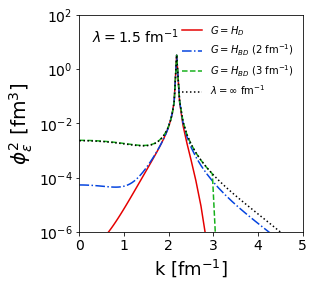

In [20]:
# Plot momentum distributions comparing initial and SRG-evolved distributions for various SRG generators

# RKE N4LO (450 MeV) using mesh with kmax = 10.0
# Deuteron
#deuteron_momentum_distribution(111, 10.0, 2.0, 120, wegner_1_5, block_diag_2, block_diag_3)
# Epsilon = 200 MeV continuum state
#continuum_state_momentum_distribution(eps, 111, '3S1', 10.0, 2.0, 120, wegner_1_5, block_diag_2, block_diag_3)